In [1]:
from pathlib import Path

import tensorflow as tf
import tensorflow_federated as tff
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

2024-07-10 15:29:04.988369: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-10 15:29:05.090934: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-10 15:29:05.225573: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-10 15:29:05.357402: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-10 15:29:05.358150: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-10 15:29:05.544218: I tensorflow/core/platform/cpu_feature_guard.cc:

AttributeError: module 'tensorflow' has no attribute 'contrib'

## Create Datasets

The datasets are created using the federated dataset for optimal comparability. The training time is a littlebit slower than with the `tensorflow_datasets` version, but the accuracy is roughly the same (difference of ~2% that I would attribute to randomness)

In [4]:
SVHN_DIR = Path().home() / '.tff/svhn'

def _load_svhn():
    svhn_spec = {
        'image': tf.TensorSpec((32, 32, 3), dtype=tf.int64),
        'label': tf.TensorSpec((), dtype=tf.int64),
    }
    train_client_data =  tff.simulation.datasets.load_and_parse_sql_client_data(str(Path(SVHN_DIR) / 'train.sqlite'), element_spec=svhn_spec, split_name=None)
    test_client_data = tff.simulation.datasets.load_and_parse_sql_client_data(str(Path(SVHN_DIR) / 'test.sqlite'), element_spec=svhn_spec, split_name=None)
    return train_client_data, test_client_data

In [7]:
fed_train_ds, fed_test_ds = _load_svhn()
train_ds = fed_train_ds.create_tf_dataset_from_all_clients()
test_ds = fed_test_ds.create_tf_dataset_from_all_clients()

In [13]:
train_ds_size = sum(1 for _ in iter(train_ds))
val_ds_size = int(0.2 * train_ds_size)
val_ds = train_ds.take(val_ds_size)
train_ds = train_ds.skip(val_ds_size)

In [15]:
sum(1 for _ in iter(train_ds)), sum(1 for _ in iter(val_ds))

(20826, 5206)

(<matplotlib.image.AxesImage at 0x770cdc55b810>,
 <tf.Tensor: shape=(), dtype=int64, numpy=9>)

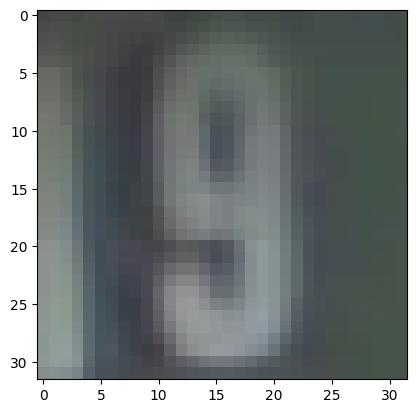

In [16]:
ex = next(iter(train_ds))
plt.imshow(ex['image']), ex['label']

In [17]:
augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomBrightness(0.3, value_range=(0.,1.)),
    tf.keras.layers.RandomContrast(0.5),
    tf.keras.layers.RandomRotation(factor=(-0.3,0.3))
])

In [18]:
def preprocess_ds(ds, is_train=False):
    def element_fn(element):
        image = element['image']
        label = element['label']
        image = tf.cast(image, dtype=tf.float32) / 255.  # rescale image
        return (image, label)
    
    if is_train:
        return (
            ds
            .map(element_fn)
            .shuffle(128)
            # .repeat(3)
            # .map(lambda x, y: (augmentation(x), y))  # augmentation doesn't really help
            .batch(512)  # just increasing the batch size improved the training process a lot idk why
        )
    else:
        return (
            ds
            .map(element_fn)
            .batch(512)
        )

In [19]:
train = preprocess_ds(train_ds, is_train=True)
val = preprocess_ds(val_ds)
test = preprocess_ds(test_ds)

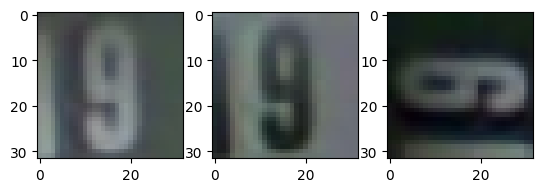

In [20]:
img = next(iter(train_ds))['image']
augmented_img = augmentation(tf.cast(img, dtype=tf.float32) / 255.)
fig, axes = plt.subplots(1,3)
axes[0].imshow(img)
axes[1].imshow(tf.image.adjust_contrast(img, -1.1))
axes[2].imshow(augmented_img)

In [21]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(10),
])

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(
    optimizer=optimizer, 
    loss=loss_object, 
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)

In [22]:
history = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
      1/Unknown - 5s 5s/step - loss: 2.3200 - accuracy: 0.1270

2024-07-04 12:15:37.369821: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 58982400 exceeds 10% of free system memory.
2024-07-04 12:15:37.485034: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 58982400 exceeds 10% of free system memory.


      2/Unknown - 6s 509ms/step - loss: 2.3053 - accuracy: 0.1367

2024-07-04 12:15:37.907158: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 58982400 exceeds 10% of free system memory.
2024-07-04 12:15:37.998221: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 58982400 exceeds 10% of free system memory.


      3/Unknown - 6s 535ms/step - loss: 2.2903 - accuracy: 0.1543

2024-07-04 12:15:38.463333: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 58982400 exceeds 10% of free system memory.


41/41 [==============================] - 31s 635ms/step - loss: 2.2312 - accuracy: 0.1946 - val_loss: 2.1807 - val_accuracy: 0.2455
Epoch 2/10
41/41 [==============================] - 30s 636ms/step - loss: 2.0499 - accuracy: 0.2834 - val_loss: 1.8273 - val_accuracy: 0.3934
Epoch 3/10
41/41 [==============================] - 30s 620ms/step - loss: 1.6609 - accuracy: 0.4555 - val_loss: 1.3619 - val_accuracy: 0.6005
Epoch 4/10
41/41 [==============================] - 30s 639ms/step - loss: 1.3055 - accuracy: 0.5972 - val_loss: 1.0856 - val_accuracy: 0.7115
Epoch 5/10
41/41 [==============================] - 30s 627ms/step - loss: 1.0797 - accuracy: 0.6787 - val_loss: 0.8910 - val_accuracy: 0.7610
Epoch 6/10
41/41 [==============================] - 31s 647ms/step - loss: 0.9375 - accuracy: 0.7259 - val_loss: 0.7687 - val_accuracy: 0.7889
Epoch 7/10
41/41 [==============================] - 30s 636ms/step - loss: 0.8309 - accuracy: 0.7549 - val_loss: 0.6987 - val_accuracy: 0.8108
Epoch 8/10

In [23]:
model.evaluate(test)

51/51 [==============================] - 22s 430ms/step - loss: 0.5513 - accuracy: 0.8464


[0.5512638092041016, 0.8463813662528992]

Text(0.5, 1.0, 'Accuracy on SVHN')

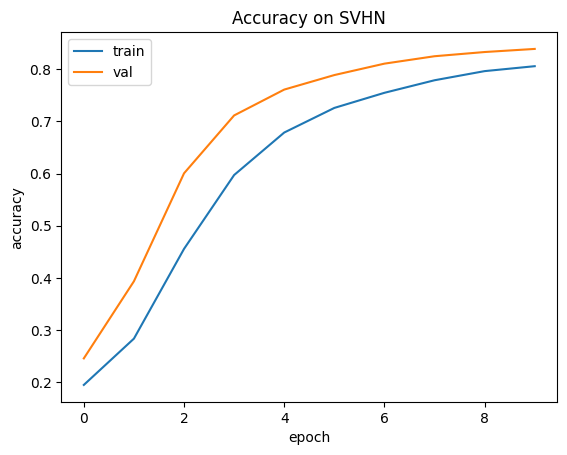

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy on SVHN')